In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from tqdm import tqdm

In [16]:
import scipy.io
content_dict = scipy.io.loadmat('stack.mat')
pad_length = 3
imgs = []
for key in content_dict.keys():
    if key[:5]=='frame':
        img1 = content_dict[key]
        imgs.append(np.pad(img1, ((pad_length, pad_length), (pad_length, pad_length))))


In [17]:
content_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'numframes', 'frame001', 'frame002', 'frame003', 'frame004', 'frame005', 'frame006', 'frame007', 'frame008', 'frame009', 'frame010', 'frame011', 'frame012', 'frame013', 'frame014', 'frame015', 'frame016', 'frame017', 'frame018', 'frame019', 'frame020', 'frame021', 'frame022', 'frame023', 'frame024', 'frame025', 'frame026', 'frame027', 'frame028', 'frame029', 'frame030', 'frame031', 'frame032', 'frame033', 'frame034', 'frame035', 'frame036', 'frame037', 'frame038', 'frame039', 'frame040', 'frame041', 'frame042', 'frame043', 'frame044', 'frame045', 'frame046', 'frame047', 'frame048', 'frame049', 'frame050', 'frame051', 'frame052', 'frame053', 'frame054', 'frame055', 'frame056', 'frame057', 'frame058', 'frame059', 'frame060', 'frame061', 'frame062', 'frame063', 'frame064', 'frame065', 'frame066', 'frame067', 'frame068', 'frame069', 'frame070', 'frame071', 'frame072', 'frame073', 'frame074', 'frame075', 'frame076', 'frame077', 'frame07

In [18]:
content_dict['s']

array([[6]], dtype=uint8)

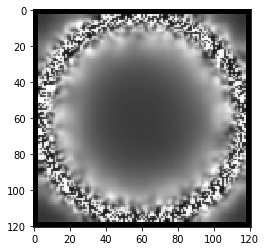

In [19]:
plt.imshow(imgs[0], cmap = 'gray')

In [20]:
def Conv2D(img, kernel):
    assert kernel.shape[0] == kernel.shape[1]
    kernel = np.flip(kernel, (0,1)) # Flipping the kernel through both axes 
    n = kernel.shape[0]
    (l,w) = img.shape
    assert n%2==1
    conv_img = np.zeros(img.shape)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            kernel_sum = 0
            intensity_sum = 0
            for k in range(i-n//2,i+n//2+1):
                for m in range(j-n//2, j+n//2+1):
                    if k<l and k>=0 and m<w and m>=0:
                        kernel_sum+=kernel[k-(i-n//2), m-(j-n//2)]
                        intensity_sum +=kernel[k-(i-n//2), m-(j-n//2)]*img[k,m]
            
            # Finally the computed image intensity for that coordinate is normalised by the kernel_sum
            conv_img[i,j] = intensity_sum/kernel_sum
    # Return the blurred image
    return conv_img


In [21]:
def ML(imgij):
    fxx = np.array([[0,0,0],[-1,2,-1],[0,0,0]])
    fyy = np.array([[0,-1,0],[0,2,0],[0,-1,0]])
    return abs(np.sum(fxx*imgij)) + abs(np.sum(fyy*imgij))
    
    
def SML(img, x, y, q):
    ML_sum = 0
    for i in range(x-q, x+q+1):
        for j in range(y-q, y+q+1):
            imgij = img[i-1:i+2, j-1:j+2]
            ML_sum+=ML(imgij)
    return ML_sum

def gaussian_interpolation(Fm, Fm1, Fm11, dm, delta_d):
    dm1 = dm-delta_d
    dm11 = dm+delta_d
    numer = (np.log(Fm)-np.log(Fm1))*(dm11**2-dm**2) - (np.log(Fm)-np.log(Fm11))*(dm1**2-dm**2)
    denom = 2*delta_d*(2*np.log(Fm) - np.log(Fm11) - np.log(Fm1))
    return numer/denom
    


In [25]:

def SFF(imgs, q, pad_l = pad_length, delta_d = 50.5):
    (l,w) = imgs[0].shape
    depths = np.zeros((l-2*pad_l, w-2*pad_l))
    focussed_img = np.zeros((l-2*pad_l, w-2*pad_l))
    for x in tqdm(range(pad_l, l-pad_l)):
        for y in range(pad_l, l-pad_l):
            Fmax = -1e9
            dm = None
            for index in range(len(imgs)):
                Fi = SML(imgs[index], x, y, q=q)
                if Fi>Fmax:
                    Fmax = Fi
                    dm = index
            dbar = 0
            if dm==0 or dm==len(imgs)-1:
                dbar = dm*delta_d
            else:
                Fmax1 = SML(imgs[dm-1], x, y, q=q)
                Fmax11 = SML(imgs[dm+1], x, y, q=q)
                dbar = gaussian_interpolation(Fmax, Fmax1, Fmax11, dm*delta_d, delta_d)
            focussed_img[x-pad_l, y-pad_l] = imgs[dm][x,y]
            depths[x-pad_l, y-pad_l] = dbar

    return depths, focussed_img    




In [ ]:
depth_maps, focussed_images = [], []
q_list = [0,1,2]
for q_val in q_list:
    depth_map, focussed_img = SFF(imgs, q=q_val)
    depth_maps.append(depth_map)
    focussed_images.append(focussed_img)

In [ ]:
f, axs = plt.subplots(1, 3, figsize = (12,9))
for i in range(3):
    axs[i].set_title("Focussed image: q = %d"%(q_list[i]))
    axs[i].imshow(focussed_images[i], cmap = 'gray')
plt.show()

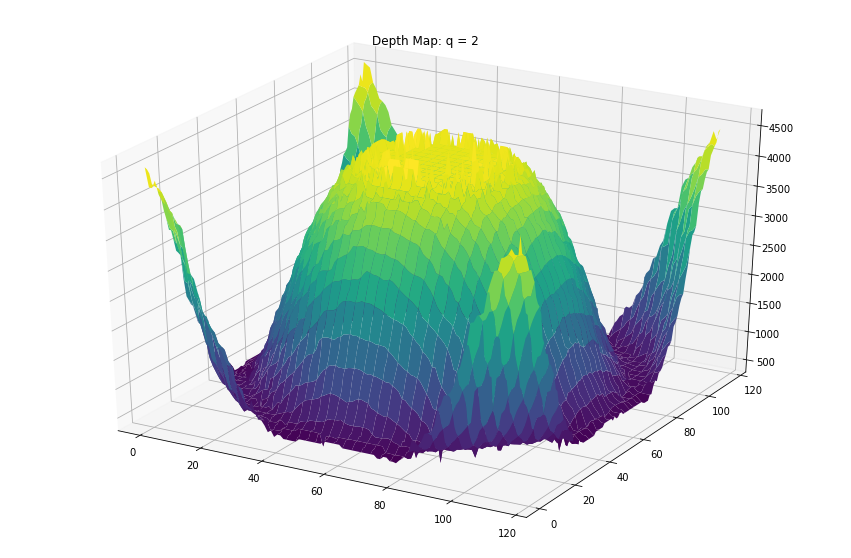

In [55]:
from mpl_toolkits.mplot3d import Axes3D

(l, w) = imgs[0].shape
lm, wm = np.meshgrid(np.arange(l-2*pad_length)+1, np.arange(w-2*pad_length)+1)
fig = plt.figure(figsize=(15,7))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plt.title("Depth Map: q = %d"%(q_list[i]))  
    ax.plot_surface(lm, wm, depth_map, cmap = 'viridis')
plt.show()

Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r

In [30]:
X.shape

(121, 121)

In [31]:
Y.shape

(121, 121)

In [32]:
depth_map.shape

(115, 115)